# Dataset

In [1]:
!gdown 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

Downloading...
From (original): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj
From (redirected): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj&confirm=t&uuid=5e873739-827f-40d6-b207-da5349c4d8ef
To: /content/celeba_hq_256.zip
100% 297M/297M [00:06<00:00, 44.8MB/s]


In [2]:
!unzip celeba_hq_256.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba_hq_256/25000.jpg  
  inflating: celeba_hq_256/25001.jpg  
  inflating: celeba_hq_256/25002.jpg  
  inflating: celeba_hq_256/25003.jpg  
  inflating: celeba_hq_256/25004.jpg  
  inflating: celeba_hq_256/25005.jpg  
  inflating: celeba_hq_256/25006.jpg  
  inflating: celeba_hq_256/25007.jpg  
  inflating: celeba_hq_256/25008.jpg  
  inflating: celeba_hq_256/25009.jpg  
  inflating: celeba_hq_256/25010.jpg  
  inflating: celeba_hq_256/25011.jpg  
  inflating: celeba_hq_256/25012.jpg  
  inflating: celeba_hq_256/25013.jpg  
  inflating: celeba_hq_256/25014.jpg  
  inflating: celeba_hq_256/25015.jpg  
  inflating: celeba_hq_256/25016.jpg  
  inflating: celeba_hq_256/25017.jpg  
  inflating: celeba_hq_256/25018.jpg  
  inflating: celeba_hq_256/25019.jpg  
  inflating: celeba_hq_256/25020.jpg  
  inflating: celeba_hq_256/25021.jpg  
  inflating: celeba_hq_256/25022.jpg  
  inflating: celeba_hq_256/25023.jpg  
  inflating: 

In [3]:
import os

file_names = os.listdir('./celeba_hq_256')
img_paths = ['./celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [4]:
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size)
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[:50]

In [5]:
len(train_imgpaths), len(val_imgpaths)

(100, 50)

In [ ]:
import numpy as np # type: ignore

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [ ]:
import torch # type: ignore
from PIL import Image # type: ignore
from torchvision import transforms # type: ignore
from torch.utils.data import Dataset # type: ignore

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=None):
        if image_size is None:
            image_size = [256, 256]
        self.img_paths = img_paths
        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        cond_image = img*(1. - mask) + mask
        return {
            "gt_image": img, "cond_image": cond_image, "mask": mask, "path": img_path
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        # Center mask
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h//4, w//4, h//4, w//4))
        return torch.from_numpy(mask).permute(2,0,1)

In [12]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [13]:
sample = next(iter(train_dataset))

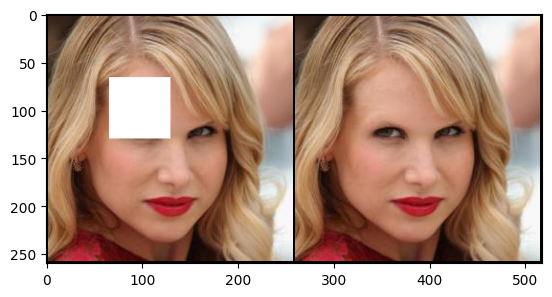

In [ ]:
import matplotlib.pyplot as plt # type: ignore
from torchvision.transforms import ToPILImage # type: ignore
from torchvision.utils import make_grid # type: ignore

grid = make_grid([sample['cond_image'], sample['gt_image']])
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True
)

In [16]:
len(train_loader)

1

# Training

In [17]:
! pip install -q torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from torchcfm.models.unet import UNetModel # type: ignore
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr=1e-4)

In [ ]:
n_epochs = 50 #1000

from tqdm import tqdm # type: ignore
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data ["gt_image"].to(device)
        mask = data ["mask"].to(device)
        x0 = torch.randn_like(x1).to(device)

        x_noise = (1.0 - mask )*x1 + mask*x0
        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)
        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()
        x_cond = xt* mask + (1.0 - mask )*x1
        vt = model(t, x_cond )

        loss = torch.mean(((vt - ut) ** 2)* mask)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

0it [00:00, ?it/s]

In [ ]:
sample['gt_image'].shape

torch.Size([3, 256, 256])

In [ ]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch . no_grad ():
        for t in t_steps [1:]:
            t = t. reshape (-1, )
            dy = model (t.to( device ), y)
            y = y + dy * dt
            y = cond_image *(1. - mask ) + mask *y
            y_values . append (y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

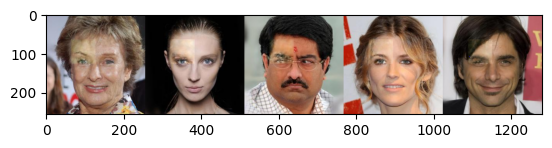

In [ ]:
import matplotlib.pyplot as plt # type: ignore
from torchvision.transforms import ToPILImage # type: ignore
from torchvision.utils import make_grid # type: ignore

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()